<a href="https://colab.research.google.com/github/TanishqSharma07/Image-Segmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

!pip install tensorflow_datasets==4.9.3
!pip install -q -U tensorflow-text tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 62.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.9.7
    Uninstalling tensorflow-datasets-4.9.7:
      Successfully uninstalled tensorflow-datasets-4.9.7


In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


#Dealing With Data

##Downloading the Oxford-IIIT Pets Dataset

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [23]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
      datapoint['segmentation_mask'],
      (128, 128),
      method = tf.image.ResizeMethod.NEAREST_NEIGHBOR
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [30]:
#Hyper Parameters
BUFFER_SIZE = 400
BATCH_SIZE = 64
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [25]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()

    self.augment_inputs = tf.keras.layers.RandomFlip(mode = "horizontal", seed = seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode = "horizontal", seed = seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [27]:
train_batches = (train_images.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

##Visualising Few Examples

In [28]:
def display(display_list):
  plt.figure(figsize = (15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

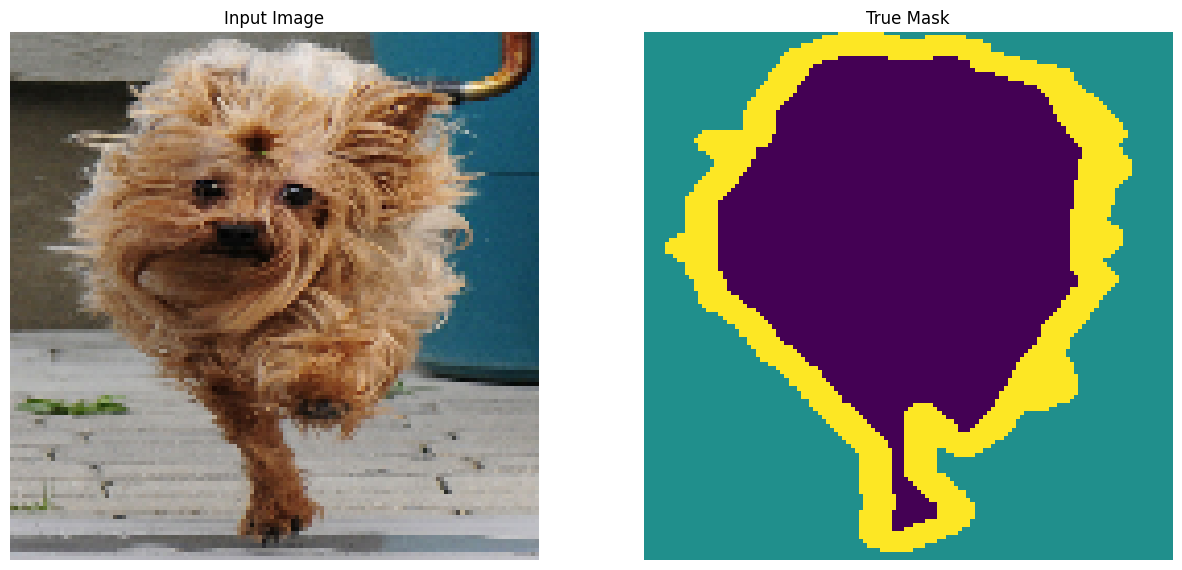

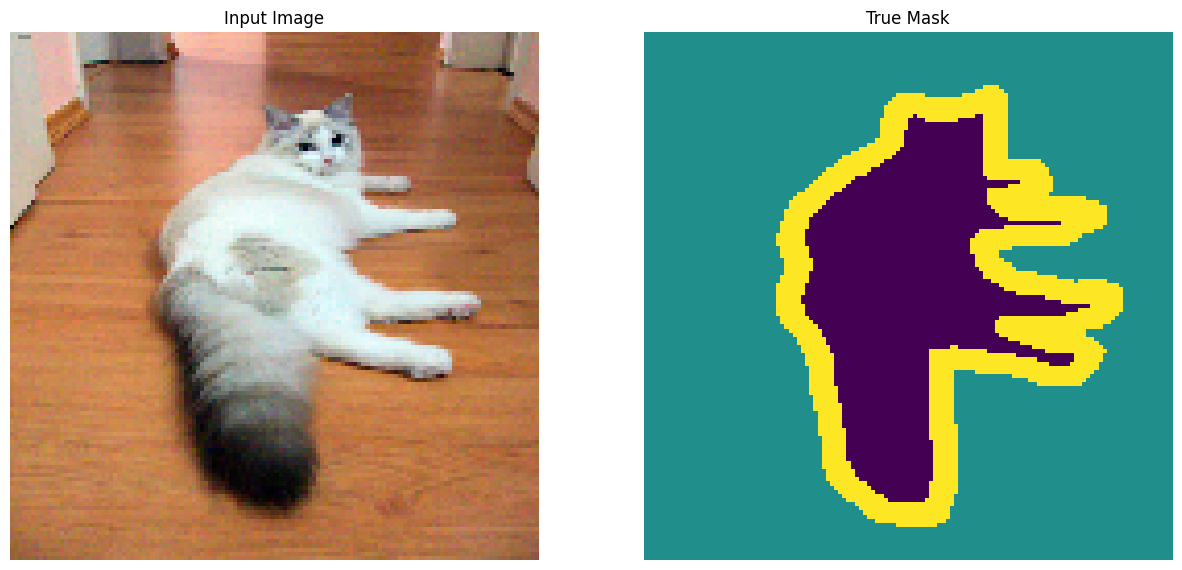

In [29]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


#Dealing With Model

##Encoder
We will use a pretrained model - Mobile Net as the encoder and choose specific outputs from the intermediate layers to concatenate later with the decoder layers

In [54]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = [128, 128, 3], include_top = False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

encoder = tf.keras.Model(inputs = base_model.input, outputs = base_model_outputs)

encoder.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


##Decoder
The decoder is simply a series of upsample blocks

In [55]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.

  Conv2DTranspose => Batchnorm => Dropout => Relu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type 'batchnorm'
    apply_dropout: If True, adds the dropout layer

  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False)
  ])


  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())


  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


In [56]:
'''These layers upsample feature maps and
concatenate them with encoder outputs.
'''
decoder = [
    upsample(512, 3),   #4x4 -> 8x8
    upsample(256, 3),   #8x8 -> 16x16
    upsample(128, 3),   #16x16 -> 32x32
    upsample(64, 3)     #32x32 -> 64x64

]



##Combine the above two to form the Final Model

In [57]:
def u_net_model(output_channels: int):

  inputs = tf.keras.layers.Input(shape = [128, 128, 3])

  #Get Encoder Feature Maps
  skips = encoder(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  #Decoder with skip connections
  for up, skip in zip(decoder, skips):
    x = up(x)
    # skip = tf.keras.layers.Cropping2D(((1, 1), (1, 1)))(skip)
    # skip = tf.keras.layers.Resizing((x.shape)[1], (x.shape)[2])(skip)
    x = tf.keras.layers.Concatenate()([x, skip])

  #Final Output Layer
  last = tf.keras.layers.Conv2DTranspose(
      filters = output_channels,
      kernel_size = 3,
      strides = 2,
      padding = 'same'
  )

  x = last(x)

  return tf.keras.Model(inputs = inputs, outputs = x)

#Train The Model

In [58]:
OUTPUT_CLASSES = 3

model = u_net_model(output_channels = OUTPUT_CLASSES)

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits = True
    ),
    metrics = ['accuracy']
)


In [59]:

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


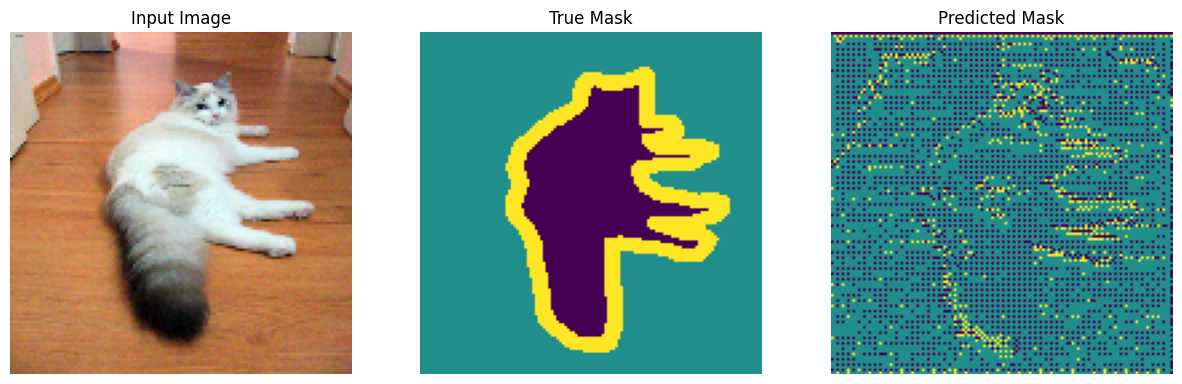

In [60]:
show_predictions()

In [61]:
from IPython.display import clear_output


class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


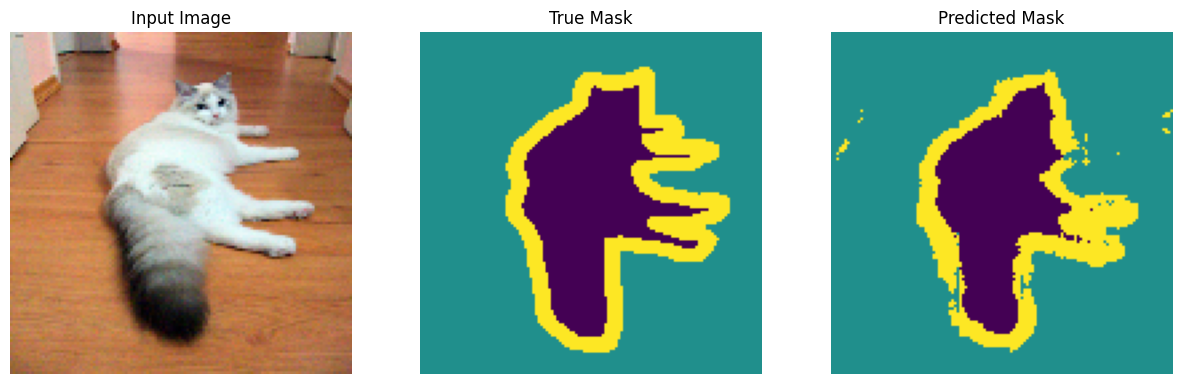


Sample Prediction after epoch 7

57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - accuracy: 0.8984 - loss: 0.2629 - val_accuracy: 0.8989 - val_loss: 0.2651


In [62]:
EPOCHS = 7



model_history = model.fit(
    train_batches,
    epochs = EPOCHS, steps_per_epoch = STEPS_PER_EPOCH,

    validation_data = test_batches,
    validation_steps = int(0.25 * len(test_batches)),
    callbacks = [DisplayCallback()]
)

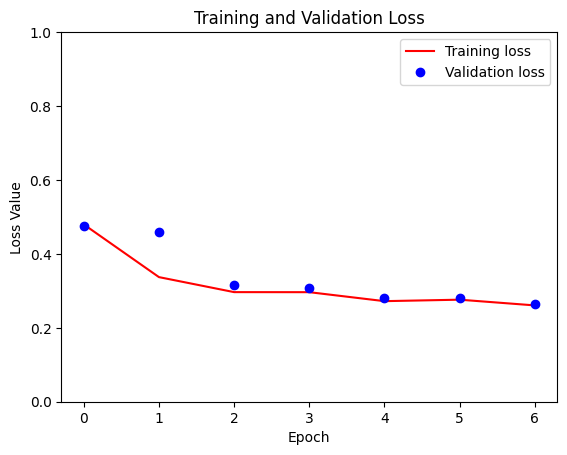

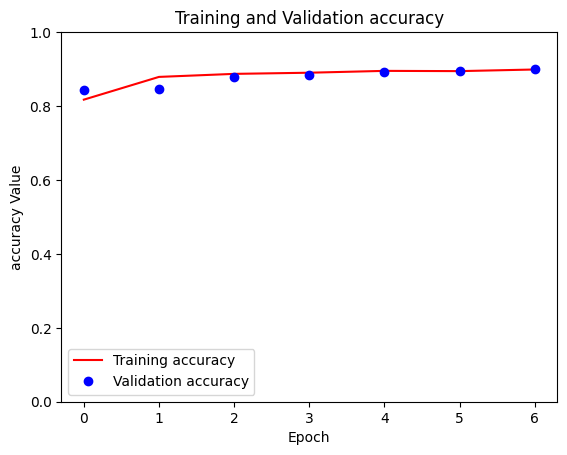

In [65]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']


plt.figure()
plt.plot(model_history.epoch, accuracy, 'r', label='Training accuracy')
plt.plot(model_history.epoch, val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

#Evaluating the model


In [66]:
results = model.evaluate(test_batches)
print(f"Model Evaluation results: {results}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.8997 - loss: 0.2627
Model Evaluation results: [0.265423446893692, 0.8985973596572876]


##Making Predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step


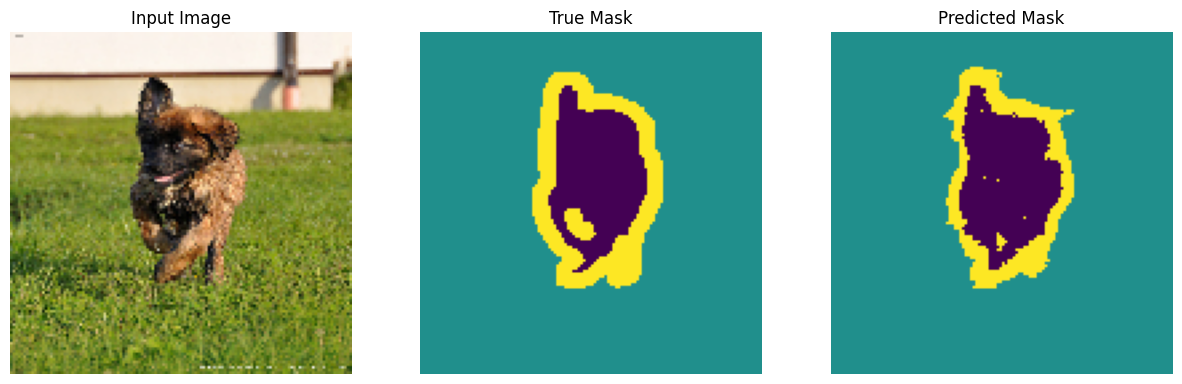

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 


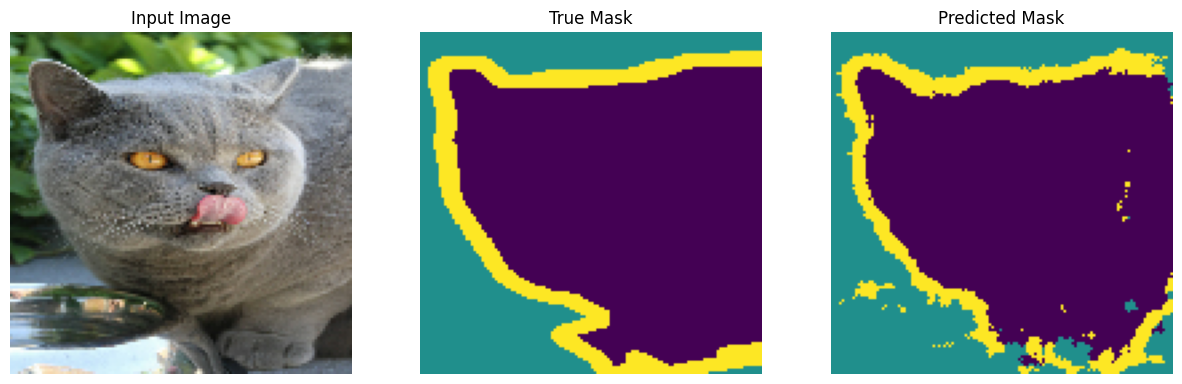

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


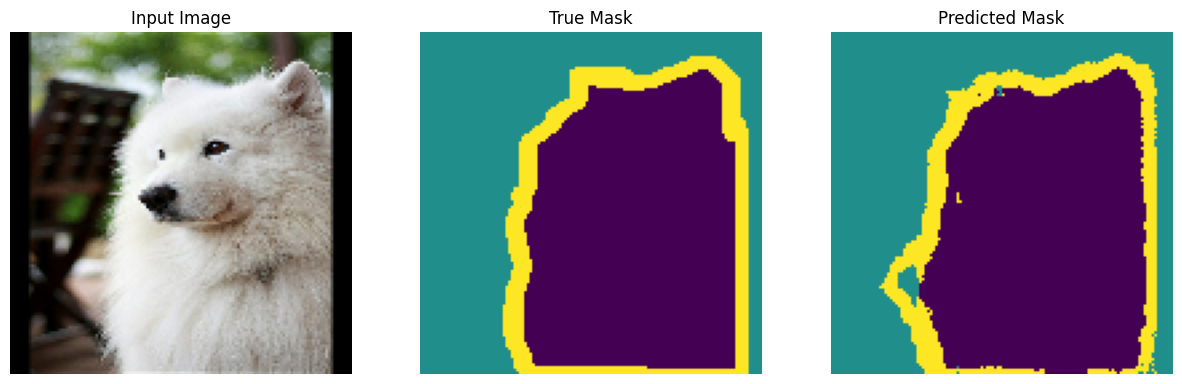

In [67]:
show_predictions(test_batches, 3)